In [2]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Preprocessor
from src.lstm_forecasting import LSTMForecaster
from sklearn.metrics import mean_squared_error

# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

In [3]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
# convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [4]:
preprocessor = Preprocessor(df=champs_elysees_df)

# On applique ton pipeline de preprocessing
df_processed = preprocessor.fit_transform(holidays_df=holidays_df, weather_df=weather_df, sports_df=football_matches_df)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))


Preprocessed Data : (8627, 43)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2025-01-16 17:00:00,4264,AV_Champs_Elysees,902.0,17.95333,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-03-22 05:00:00,4264,AV_Champs_Elysees,330.0,3.91556,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-11-12 15:00:00,4264,AV_Champs_Elysees,646.0,18.73444,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-03-20 19:00:00,4264,AV_Champs_Elysees,1167.0,19.24278,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-08-18 11:00:00,4264,AV_Champs_Elysees,736.0,13.35889,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


# LSTM Forecasting

In [ ]:
forecaster = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = forecaster.prepare_data(df_processed)

# Training
history = forecaster.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0240 - val_loss: 0.0140
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0130 - val_loss: 0.0110
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0115 - val_loss: 0.0104
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0110 - val_loss: 0.0109


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Débit horaire : RMSE = 214.24, Mean = 738.55, Relative error = 29.01%
Taux d'occupation : RMSE = 8.24, Mean = 16.53, Relative error = 49.82%


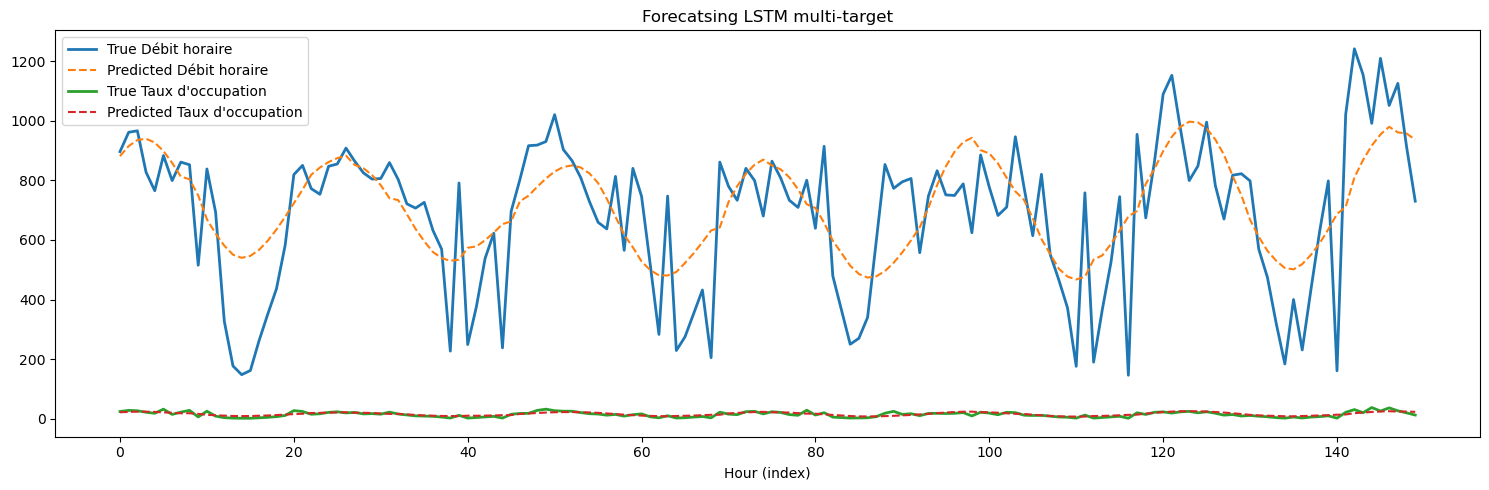

In [15]:
y_test_inv, y_pred_inv = forecaster.evaluate(X_test, y_test)

# Visualisation on the first 72 hours
forecaster.plot_predictions(y_test_inv, y_pred_inv, n_plot=150)

In [14]:
# Concaténer train + test pour la CV (on prend tout)
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

forecaster.time_series_cv(X_all, y_all, n_splits=5, epochs=5, batch_size=32)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0385 - val_loss: 0.0146
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0188 - val_loss: 0.0139
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0172 - val_loss: 0.0135
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0158 - val_loss: 0.0125
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0141 - val_loss: 0.0106
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Débit horaire : RMSE = 246.19, Mean = 709.81, Relative error = 34.68%
Taux d'occupation : RMSE = 7.15, Mean = 13.86, Relative error = 51.61%
Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0304 - val_loss: 0.0190
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0158 - val_loss: 0.0175
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0115 - val_loss: 0.0134
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.011

# XGBoost model

In [17]:
from src.xgb_forecasting import XGBoostModel

Train set: (1417, 6), Test set: (72, 6) (72 hours)
Débit horaire : RMSE = 262.18, Mean = 779.11, Relative Error = 33.65%
Taux d'occupation : RMSE = 9.08, Mean = 17.25, Relative Error = 52.62%


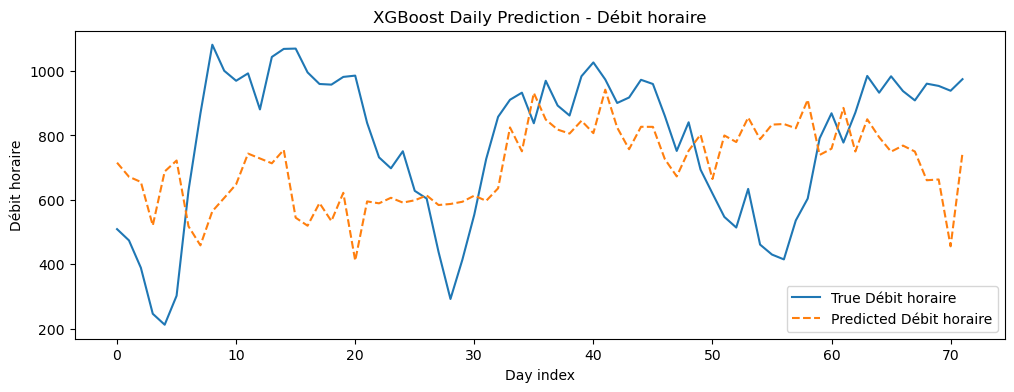

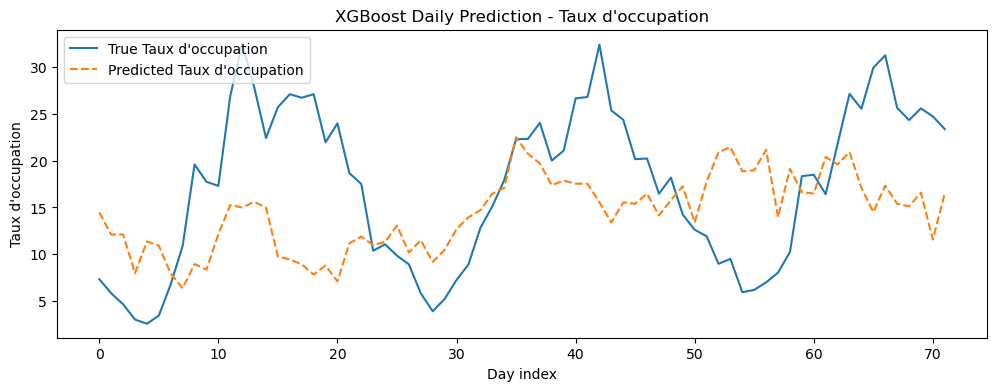

In [23]:
targets = ['Débit horaire', "Taux d'occupation"]
features_xgb = ['is_holiday',
                'is_sport_event',
                'temperature_2m (°C)','wind_speed_10m (km/h)',
                'precipitation (mm)','cloud_cover (%)'] 

df_xgb = df_processed.copy()
df_xgb['lag_1d'] = df_xgb['Débit horaire'].shift(24)
df_xgb['lag_1w'] = df_xgb['Débit horaire'].shift(24*7)

df_xgb = df_xgb.dropna(subset=['lag_1d', 'lag_1w'] + targets).copy()

xgb_model = XGBoostModel(df_xgb, features_xgb, targets)
xgb_model.prepare_data(horizon=72)

xgb_model.fit()

# Prediction on the test set
y_test, y_pred = xgb_model.evaluate()

# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:, i], label=f"True {target}")
    plt.plot(y_pred[:, i], '--', label=f"Predicted {target}")
    plt.title(f"XGBoost Daily Prediction - {target}")
    plt.xlabel("Day index")
    plt.ylabel(target)
    plt.legend()
    plt.show()



In [ ]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 285.95, std = 19.71
Taux d'occupation : CV RMSE mean = 10.03, std = 2.28


# Hybrid LSTM + XGBoost model 

In [8]:
## Hybrid LSTM + XGBoost model

### LSTM for short-term patterns
lstm_model = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = lstm_model.prepare_data(df_processed)

# Training
history = lstm_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)

# Predictions LSTM
y_test_inv, y_pred_inv = lstm_model.evaluate(X_test, y_test)

### XGBoost for long-term patterns
# Compute daily averages
# daily_df = df_processed.groupby('date').agg({
#     'Débit horaire':'mean',
#     "Taux d'occupation":'mean',
#     'is_holiday':'first',
#     'is_sport_event':'first',
#     'temperature_2m (°C)':'mean',
#     'wind_speed_10m (km/h)':'mean',
#     'precipitation (mm)':'mean',
#     'cloud_cover (%)':'mean'
# }).reset_index()

# Features for XGBoost
features_xgb = ['is_holiday','is_sport_event','temperature_2m (°C)',
                'wind_speed_10m (km/h)','precipitation (mm)','cloud_cover (%)']

# Instanciate XGBoost
xgb_model = XGBoostModel(df_processed, features_xgb, lstm_model.targets)
xgb_model.prepare_data(horizon=72)
xgb_model.fit()

# Predictions XGBoost (long-term)
y_pred_xgb = xgb_model.predict()


Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0223 - val_loss: 0.0125
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0126 - val_loss: 0.0113
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0114 - val_loss: 0.0105
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0112 - val_loss: 0.0104
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Débit horaire : RMSE = 213.51, Mean = 738.55, Relative error = 28.91%
Taux d'occupation : RMSE = 8.21, Mean = 16.53, Relative error = 49.67%
Train set: (1417, 6), Test set: (72, 6) (72 hours)


In [48]:
# Combine LSTM and XGBoost predictions
y_test_inv, y_pred_lstm_array = lstm_model.evaluate(X_test, y_test)
print("LSTM Prediction Array Shape :", y_pred_lstm_array.shape)
y_pred_lstm_hourly = y_pred_lstm_array[-1, :, :]

alpha = 0.7
y_pred_final = alpha * y_pred_lstm_hourly + (1-alpha) * y_pred_xgb
print("Final Prediction Shape :", y_pred_final.shape)

y_true = y_test_inv[-1, :, :]  # real 72h for the last batch of LSTM
y_pred = y_pred_final           # 72h combined LSTM + XGBoost

for i, target in enumerate(lstm_model.targets):
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
    mean_val = np.mean(y_true[:, i])
    rel_error = 100 * rmse / mean_val
    print(f"{target} : RMSE = {rmse:.2f}, Mean = {mean_val:.2f}, Relative Error = {rel_error:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Débit horaire : RMSE = 213.51, Mean = 738.55, Relative error = 28.91%
Taux d'occupation : RMSE = 8.21, Mean = 16.53, Relative error = 49.67%
LSTM Prediction Array Shape : (1678, 72, 2)
Final Prediction Shape : (72, 2)
Débit horaire : RMSE = 187.56, Mean = 772.65, Relative Error = 24.27%
Taux d'occupation : RMSE = 5.96, Mean = 17.08, Relative Error = 34.91%


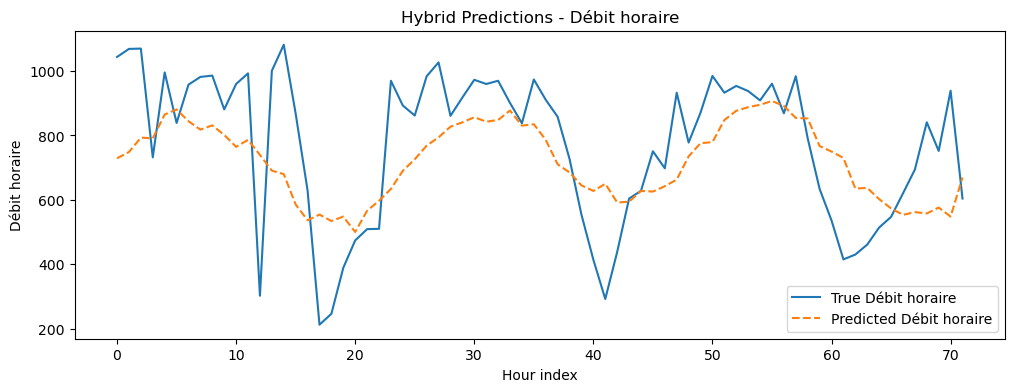

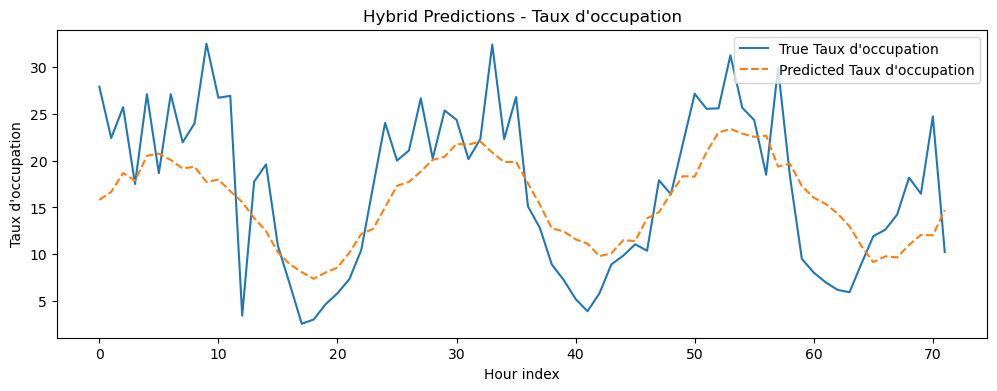

In [26]:
# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test_inv[-1, :, :][:, i], label=f"True {target}")
    plt.plot(y_pred_final[:, i], '--', label=f"Predicted {target}")
    plt.title(f"Hybrid Predictions - {target}")
    plt.xlabel("Hour index")
    plt.ylabel(target)
    plt.legend()
    plt.show()